# Imports and Global Variables

In [1]:
!pip install emoji contractions tiktoken wandb

In [2]:
from google.colab import drive
drive.mount('/content/drive')
%cd drive/MyDrive/AdvDeepLearning/SentimentAnalysis/

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/MyDrive/AdvDeepLearning/SentimentAnalysis


In [3]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from google.colab import userdata
import matplotlib.pyplot as plt
from collections import Counter
import seaborn as sns
import pandas as pd
import numpy
import os

from nltk.stem.porter import PorterStemmer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
import contractions
import string
import emoji
import re
import nltk
nltk.download('stopwords')
nltk.download('wordnet')

from sklearn.metrics import f1_score, precision_score, recall_score, accuracy_score
from torch.utils.data import Dataset, DataLoader, random_split
from sklearn.feature_extraction.text import TfidfVectorizer
from model import GPT, GPTConfig, Block, LayerNorm # Don't forget to upload model.py to /content | https://github.com/karpathy/nanoGPT/blob/master/model.py
from transformers import BertTokenizer
import torch.nn.functional as F
import torch.nn as nn
import scipy.sparse
import pandas as pd
import numpy as np
import datetime
import tiktoken
import torch
import wandb
import math
import os


### Global Variables ###
DATA_DIR = r'./sst2/'
SEED = 12345
torch.manual_seed(SEED)
numpy.random.seed(SEED)
project_name = 'sentiment_classification'
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


cuda


# Data Loading

In [4]:
train_df = pd.read_csv(os.path.join(DATA_DIR, 'train.csv'))
test_df = pd.read_csv(os.path.join(DATA_DIR, 'test.csv'))
train_df, val_df = train_test_split(train_df, test_size=0.2, random_state=SEED)
train_df['data_split_type'] = "train"
val_df['data_split_type'] = "val"
test_df['data_split_type'] = "test"
df = pd.concat([train_df,val_df, test_df])
df.reset_index(drop=True, inplace=True)
df['sentiment'] = df['label']#.map({'positive': 1, 'negative': 0})
df['text_cleaned'] = df.sentence

# PreProcess

In [5]:
# # Only Customer Conversations | I will rerun this process with uncommenting this section when I am doing hyperparameter tunning
# df['text_cleaned'] = df['text_cleaned'].apply(
#     lambda x: "\n".join([line.split(":", 1)[1].strip() for line in x.split('\n') if line.startswith("Customer:")]))

# Lowering Case:
df['text_cleaned'] = df['text_cleaned'].str.lower()

# Update the function to remove the entire specified pattern including variations in the agent's name
def remove_full_pattern(text):
    # Extended pattern to remove, including variations in agent names
    full_pattern = r"Thank you for calling BrownBox Customer Support\. My name is \w+\. How may I assist you today\?"
    # Remove the extended pattern
    text = re.sub(full_pattern, "", text, flags=re.IGNORECASE)
    return text.strip()

# Apply the updated function to the 'conversation' column
df['text_cleaned'] = df['text_cleaned'].apply(remove_full_pattern)

# Cleaning the "Agent:" and "Customer:"
df['text_cleaned'] = df['text_cleaned'].str.replace(r"\b(Agent:|Customer:)\s*", "", regex=True)

# Remove email addresses and websites from the 'text_cleaned' column in one line
df['text_cleaned'] = df['text_cleaned'].apply(lambda text: re.sub(r"\S+@\S+|www\.\S+\.com", "", text))

# Removing punctuation, numbers, extra spaces and replacing repetitions of punctuation
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: x.translate(str.maketrans('', '', string.punctuation)))
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r'\d+', '', x))
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: ' '.join(x.split()))
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r'(\W)\1+', r'\1', x))

# Convert Emojis to Words
def convert_emojis_to_words(text):
    converted_text = emoji.demojize(text)
    return converted_text
df['text_cleaned'] = df['text_cleaned'].apply(convert_emojis_to_words)

# Removing special characters
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: re.sub(r"[^\w\s]", '', x))

# Removing contractions
df['text_cleaned'] = df['text_cleaned'].apply(lambda x: contractions.fix(x))

# Removing stop words:
stop_words_set = set(stopwords.words('english'))
no_stopwords = []
for sentence in df["text_cleaned"]:
    # Use the new variable name here
    no_stopwords.append(' '.join(word for word in sentence.split() if word not in stop_words_set))
df["text_cleaned"]=no_stopwords

# Lemmitization
lemmatizer = WordNetLemmatizer()
def lemmatize_words(text):
    return " ".join([lemmatizer.lemmatize(word) for word in text.split()])

df["text_cleaned"] = df["text_cleaned"].apply(lambda text: lemmatize_words(text))

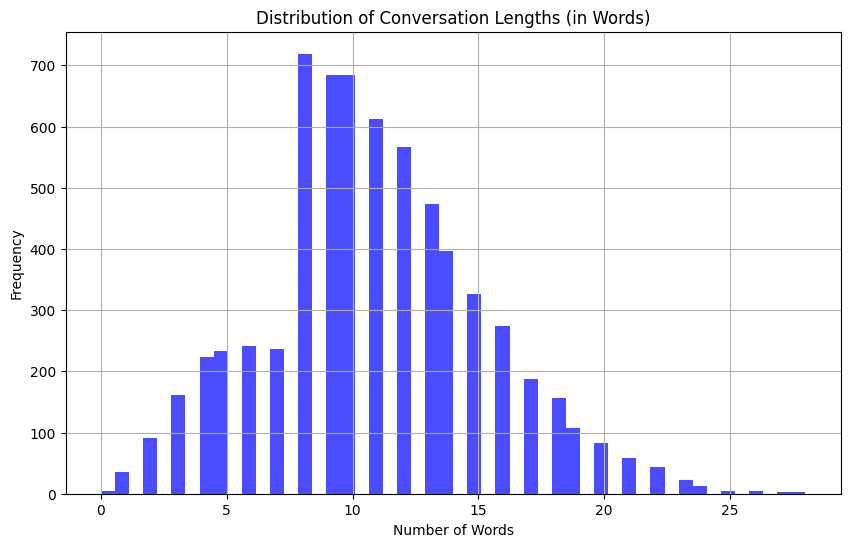

In [6]:
# Calculate the number of words in each conversation |  Before changing the preprocess part for hyperparmater tunning
df['word_count'] = df['text_cleaned'].str.split().str.len()
df = df[~((df['word_count'] < 8) & (df['data_split_type'] == 'train'))] #Removing no conversation in train dataset
# Plotting the histogram of conversation lengths
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Conversation Lengths (in Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

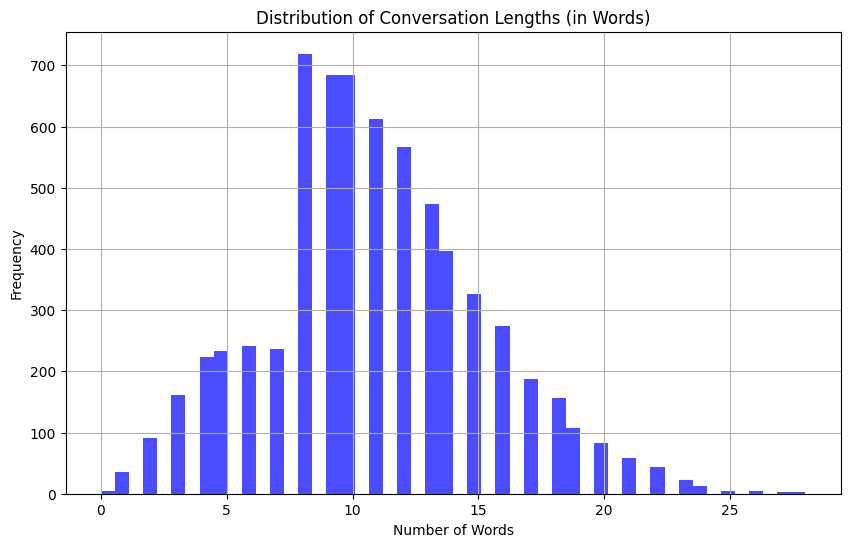

In [7]:
# Calculate the number of words in each conversation |  After changing the preprocess part for hyperparmater tunning
df['word_count'] = df['text_cleaned'].str.split().str.len()
df = df[~((df['word_count'] < 8) & (df['data_split_type'] == 'train'))] #Removing no conversation in train dataset
# Plotting the histogram of conversation lengths
plt.figure(figsize=(10, 6))
plt.hist(df['word_count'], bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Conversation Lengths (in Words)')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

# Model Design

In [17]:
class Attention(nn.Module):
    def __init__(self, config, layer_num):
        super().__init__()
        self.layer_used = config.attention_layer
        if config.attention_layer == "CausalSelfAttention":
            self.attn_layer = CausalSelfAttention(config)
        elif config.attention_layer == "MomentumAttention":
            self.attn_layer = MomentumAttention(config, layer_num)
        elif config.attention_layer == "AdaGradAttention":
            self.attn_layer = AdaGradAttention(config, layer_num)
        elif config.attention_layer == "RMSPropAttention":
            self.attn_layer = RMSPropAttention(config, layer_num)
        elif config.attention_layer == "AdamAttention":
            self.attn_layer = AdamAttention(config, layer_num)
        elif config.attention_layer == "MuonAttention":
            self.attn_layer = MuonAttention(config, layer_num)
        else:
            raise ValueError(f"config.attention_layer not valid.\n \
                             Valid values: CausalSelfAttention, MomentumAttention, AdaGradAttention, \
                             RMSPropAttention, AdamAttention, MuonAttention\n \
                             Current: {config.attention_layer}")
        print(f"Attention used: {config.attention_layer}")

    def forward(self, x, m):
      if self.layer_used == "AdamAttention":
        return self.attn_layer(x, m, v)
      return self.attn_layer(x, m)

class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')
        if not self.flash:
            print("WARNING: using slow attention. Flash Attention requires PyTorch >= 2.0")
            # causal mask to ensure that attention is only applied to the left in the input sequence
            self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                        .view(1, 1, config.block_size, config.block_size))

    def forward(self, x, m):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=True)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y, None

# Momentum-Based Attention
class MomentumAttention(nn.Module):
    """
    Momentum Attention
    Introduced in https://arxiv.org/pdf/2212.10559v2
    """

    def __init__(self, config, layer_num):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias",
                             torch.tril(torch.ones(config.block_size, config.block_size))
                                  .view(1, 1, config.block_size, config.block_size))

        # momentum
        t = layer_num
        eta = torch.tensor([config.momentum_eta]).to("cuda")
        self.momentum_scale = torch.pow(eta, t)

    def forward(self, x, m):
        """
        Forward implementation of MomentumAttention
        params:
            x: input (B, T, C)
                B - batch size
                T - sequence length
                C - embedding dimensionality (n_embd)
            m: momentum term at t-1
            t: t-th layer
        returns:
            y: momentum attention
            m: momentum term at t
        """
        B, T, C = x.size()
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))

        # momentum
        y = y + m
        m = m + self.momentum_scale * y
        return y, m

class AdaGradAttention(nn.Module):
    """
    AdaGrad Attention
    Introduced in 10-707 Final Project
    """
    #TODO: Implement AdaGrad Attention

    def __init__(self, config, layer_num):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias",
                             torch.tril(torch.ones(config.block_size, config.block_size))
                                  .view(1, 1, config.block_size, config.block_size))

        # momentum
        t = layer_num
        eta = torch.tensor([config.momentum_eta]).to("cuda")
        self.momentum_scale = torch.pow(eta, t)
        self.eps = 1E-5

    def forward(self, x, m):
        """
        Forward implementation of MomentumAttention
        params:
            x: input (B, T, C)
                B - batch size
                T - sequence length
                C - embedding dimensionality (n_embd)
            m: momentum term at t-1
            t: t-th layer
        returns:
            y: momentum attention
            m: momentum term at t
        """
        B, T, C = x.size()
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))

        # AdaGrad momentum
        y = y + m
        X = y * y
        adagrad_update = torch.pow(X+self.eps, -0.5) * y
        m = m + self.momentum_scale * adagrad_update
        return y, m

class RMSPropAttention(nn.Module):
    """
    RMSProp Attention
    Introduced in 10-707 Final Project
    """
    def __init__(self, config, layer_num):
        super().__init__()
        assert config.n_embd % config.n_head == 0

        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)

        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout

        # causal mask to ensure that attention is only applied to the left in the input sequence
        self.register_buffer("bias",
                             torch.tril(torch.ones(config.block_size, config.block_size))
                                  .view(1, 1, config.block_size, config.block_size))

        # momentum
        self.rho = 0.1
        self.eps = 1e-8
        self.layer_num = layer_num
        self.eta = config.momentum_eta
        self.momentum_scale = torch.pow(torch.tensor([self.eta]).to("cuda"), self.layer_num)

        print(f"self.rho = {self.rho}")


    def forward(self, x, m):
        """
        Forward implementation of RMSPropAttention
        params:
            x: input (B, T, C)
                B - batch size
                T - sequence length
                C - embedding dimensionality (n_embd)
            m: momentum term at t-1
            t: t-th layer
        returns:
            y: momentum attention
            m: momentum term at t
        """
        B, T, C = x.size()
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        att = att.masked_fill(self.bias[:,:,:T,:T] == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C)
        y = self.resid_dropout(self.c_proj(y))

        # RMSProp momentum
        if m is None:
            m = torch.zeros_like(y)

        y = y + m
        X = y * y
        rmsprop_update = torch.pow(X+self.eps, -0.5) * y
        m = self.rho * m + (1 - self.rho) * rmsprop_update
        # print(m.shape)

        # y = y + m
        # X = y * y
        # adagrad_update = torch.pow(X+self.eps, -0.5) * y
        # m = m + self.momentum_scale * adagrad_update
        return y, m

In [9]:
class FullSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        # flash attention make GPU go brrrrr but support is only in PyTorch >= 2.0
        self.flash = hasattr(torch.nn.functional, 'scaled_dot_product_attention')

    def forward(self, x):
        B, T, C = x.size() # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v  = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C // self.n_head).transpose(1, 2) # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
        if self.flash:
            # efficient attention using Flash Attention CUDA kernels
            y = torch.nn.functional.scaled_dot_product_attention(q, k, v, attn_mask=None, dropout_p=self.dropout if self.training else 0, is_causal=False)
        else:
            # manual implementation of attention
            att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
            att = F.softmax(att, dim=-1)
            att = self.attn_dropout(att)
            y = att @ v # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        y = y.transpose(1, 2).contiguous().view(B, T, C) # re-assemble all head outputs side by side

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y
class MLP(nn.Module):

    def __init__(self, config):
        super().__init__()
        self.c_fc    = nn.Linear(config.n_embd, 4 * config.n_embd, bias=config.bias)
        self.gelu    = nn.GELU()
        self.c_proj  = nn.Linear(4 * config.n_embd, config.n_embd, bias=config.bias)
        self.dropout = nn.Dropout(config.dropout)

    def forward(self, x):
        x = self.c_fc(x)
        x = self.gelu(x)
        x = self.c_proj(x)
        x = self.dropout(x)
        return x

class Block(nn.Module):

    def __init__(self, config, layer_num):
        super().__init__()
        self.ln_1 = LayerNorm(config.n_embd, bias=config.bias)
        self.attn = Attention(config, layer_num)
        self.ln_2 = LayerNorm(config.n_embd, bias=config.bias)
        self.mlp = MLP(config)

    def forward(self, x, m):
        x = self.ln_1(x)
        x_attn, m_attn = self.attn(x, m)
        x = x + x_attn
        x = self.ln_2(x)
        x = x + self.mlp(x)
        return x, m_attn

class BumbleBee(GPT):
    def __init__(self, config, num_classes=3): # The output of the sentimenet analysis will be 0, 1, 2.
        super().__init__(config)

        self.config = config

        self.transformer = nn.ModuleDict(dict(
            wte = nn.Embedding(config.vocab_size, config.n_embd),
            wpe = nn.Embedding(config.block_size, config.n_embd),
            drop = nn.Dropout(config.dropout),
            h = nn.ModuleList([Block(config, i) for i in range(config.n_layer)]),
            ln_f = LayerNorm(config.n_embd, bias=config.bias),
        ))
        # Override the lm_head with a new linear layer for sentiment classification
        self.lm_head = torch.nn.Linear(config.n_embd, num_classes, bias=False)

    def forward(self, idx):
        device = idx.device
        b, t = idx.size()
        assert t <= self.config.block_size, f"Cannot forward sequence of length {t}, block size is only {self.config.block_size}"
        pos = torch.arange(0, t, dtype=torch.long, device=device)  # shape (t)

        # Forward the GPT model
        tok_emb = self.transformer.wte(idx)  # token embeddings of shape (b, t, n_embd)
        pos_emb = self.transformer.wpe(pos)  # position embeddings of shape (t, n_embd)
        x = self.transformer.drop(tok_emb + pos_emb)
        self.m = torch.zeros((self.config.n_embd)).to("cuda")
        for block in self.transformer.h:
            x, self.m = block(x, self.m)
        x = self.transformer.ln_f(x)

        # Aggregate sequence representations (average over the sequence)
        x = torch.mean(x, dim=1)

        # Pass through the modified linear layer to get class logits
        logits = self.lm_head(x)

        return logits

    @classmethod
    def from_pretrained(cls, model_type, override_args=None):
        assert model_type in {'gpt2', 'gpt2-medium', 'gpt2-large', 'gpt2-xl'}
        override_args = override_args or {} # default to empty dict
        # only dropout can be overridden see more notes below
        assert all(k == 'dropout' for k in override_args)
        from transformers import GPT2LMHeadModel
        print("loading weights from pretrained gpt: %s" % model_type)

        # n_layer, n_head and n_embd are determined from model_type
        config_args = {
            'gpt2':         dict(n_layer=12, n_head=12, n_embd=768),  # 124M params
            'gpt2-medium':  dict(n_layer=24, n_head=16, n_embd=1024), # 350M params
            'gpt2-large':   dict(n_layer=36, n_head=20, n_embd=1280), # 774M params
            'gpt2-xl':      dict(n_layer=48, n_head=25, n_embd=1600), # 1558M params
        }[model_type]
        print("forcing vocab_size=50257, block_size=1024, bias=True")
        config_args['vocab_size'] = 50257 # always 50257 for GPT model checkpoints
        config_args['block_size'] = 1024 # always 1024 for GPT model checkpoints
        config_args['bias'] = True # always True for GPT model checkpoints



        # we can override the dropout rate, if desired
        if 'dropout' in override_args:
            print(f"overriding dropout rate to {override_args['dropout']}")
            config_args['dropout'] = override_args['dropout']
        # create a from-scratch initialized minGPT model
        config = GPTConfig(**config_args)
        model = BumbleBee(config)
        sd = model.state_dict()
        sd_keys = sd.keys()
        sd_keys = [k for k in sd_keys if not k.endswith('.attn.bias')] # discard this mask / buffer, not a param

        # init a huggingface/transformers model
        model_hf = GPT2LMHeadModel.from_pretrained(model_type)
        sd_hf = model_hf.state_dict()

        # copy while ensuring all of the parameters are aligned and match in names and shapes
        sd_keys_hf = sd_hf.keys()
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.masked_bias')] # ignore these, just a buffer
        sd_keys_hf = [k for k in sd_keys_hf if not k.endswith('.attn.bias')] # same, just the mask (buffer)
        transposed = ['attn.c_attn.weight', 'attn.c_proj.weight', 'mlp.c_fc.weight', 'mlp.c_proj.weight']
        # basically the openai checkpoints use a "Conv1D" module, but we only want to use a vanilla Linear
        # this means that we have to transpose these weights when we import them
        assert len(sd_keys_hf) == len(sd_keys), f"mismatched keys: {len(sd_keys_hf)} != {len(sd_keys)}"
        for k in sd_keys_hf:
            if any(k.endswith(w) for w in transposed):
                # special treatment for the Conv1D weights we need to transpose
                assert sd_hf[k].shape[::-1] == sd[k].shape
                with torch.no_grad():
                    sd[k].copy_(sd_hf[k].t())
            else:
                # vanilla copy over the other parameters
                if k != 'lm_head.weight': # Except Last layer
                    assert sd_hf[k].shape == sd[k].shape
                    with torch.no_grad():
                        sd[k].copy_(sd_hf[k])

        return model

class CustomerSentimentDataset(Dataset):
    def __init__(self, df, tokenizer, max_length=256, text_column='text_cleaned', sentiment_column='sentiment',):
        self.data = df
        self.texts = self.data[text_column].values
        self.labels = self.data[sentiment_column].values
        self.tokenizer = tokenizer
        self.max_length = max_length

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]

        # Use the tokenizer's method to encode the text
        input_ids = self.tokenizer.encode(text)

        # Ensure the sequence is at most max_length
        input_ids = input_ids[:self.max_length]

        # Padding if necessary to ensure all sequences are of the same length
        padding_length = self.max_length - len(input_ids)
        if padding_length > 0:
            # Append zeros at the end for padding
            input_ids = input_ids + [0] * padding_length

        # Ensure it returns a torch tensor
        input_ids = torch.tensor(input_ids, dtype=torch.long)

        return input_ids, torch.tensor(label, dtype=torch.long)

# Training & Evaluation Metric Definations

In [21]:
def train_and_evaluate():
    current_time = datetime.datetime.now().strftime("%d-%m-%Y_%H-%M-%S")
    wandb.init(project="customser_service_sentiment_analysis", name=f"run_{current_time}")
    config = wandb.config

    if config.init_from == 'scratch':
        model_config = GPTConfig(vocab_size=config.vocab_size,
                                 block_size=config.block_size,
                                 n_layer=config.n_layer,
                                 n_head=config.n_head,
                                 n_embd=config.n_embd,
                                 dropout=config.dropout,
                                 attention_layer="RMSPropAttention")
        model = BumbleBee(model_config).to(device)
    elif str(config.init_from).startswith('gpt'):
        model_config = dict(dropout=config.dropout)
        model = BumbleBee.from_pretrained(model_type=config.init_from, override_args=model_config).to(device)
    else:
        print('please select correct model!')

    optimizer = model.configure_optimizers(weight_decay=config.weight_decay,
                                           learning_rate=config.learning_rate,
                                           betas=(config.beta1, config.beta2),
                                           device_type=device)

    train_loader = DataLoader(train_dataset, batch_size=config.batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=config.batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=config.batch_size, shuffle=False)

    best_f1_macro = 0
    best_val_loss = float('inf')
    best_model_path = ""

    for epoch in range(config.epochs):
        model.train()
        # Initialize lists to store batch metrics
        train_losses, train_f1s, train_precs, train_recs, train_accs = [], [], [], [], []
        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            optimizer.zero_grad()
            logits = model(inputs)
            loss = F.cross_entropy(logits, labels)
            loss.backward()
            torch.nn.utils.clip_grad_norm_(model.parameters(), config.max_grad_norm)
            optimizer.step()

            # Calculate and store batch metrics
            train_losses.append(loss.item())
            predictions = logits.argmax(dim=1).cpu().numpy()
            labels_np = labels.cpu().numpy()
            train_f1s.append(f1_score(labels_np, predictions, average='macro'))
            train_precs.append(precision_score(labels_np, predictions, average='macro', zero_division=0))
            train_recs.append(recall_score(labels_np, predictions, average='macro', zero_division=0))
            train_accs.append(accuracy_score(labels_np, predictions))

        # Calculate average metrics over all batches
        avg_train_loss = np.mean(train_losses)
        avg_train_f1 = np.mean(train_f1s)
        avg_train_prec = np.mean(train_precs)
        avg_train_rec = np.mean(train_recs)
        avg_train_acc = np.mean(train_accs)

        model.eval()
        val_loss, val_f1, val_prec, val_rec, val_acc, val_conf_matrix = evaluate(model, val_loader)
        print(f"\nEpoch {epoch+1}, Train Loss: {avg_train_loss:.2f}, Train F1 Macro: {avg_train_f1:.2f}, Train Precision Macro: {avg_train_prec:.2f}, Train Recall Macro: {avg_train_rec:.2f}, Train Accuracy: {avg_train_acc:.2f}")
        print(f"Epoch {epoch+1}, Val Loss: {val_loss:.2f}, Val F1 Macro: {val_f1:.2f}, Val Precision Macro: {val_prec:.2f}, Val Recall Macro: {val_rec:.2f}, Val Accuracy: {val_acc:.2f}")

        # Saving the best F1 macro result model
        if val_f1 > best_f1_macro:
            best_f1_macro = val_f1
            best_model_path = f"{DATA_DIR}/best_model_{current_time}.pt"
            checkpoint = {
                'model': model.state_dict(),
                'optimizer': optimizer.state_dict(),
                'model_args': model_config,
                'epoch_num': epoch+1,
                'best_val_loss': best_val_loss,
                'config': {k: v for k, v in dict(wandb.config).items()},
            }
            torch.save(checkpoint, best_model_path)

        # Log both training and validation metrics to W&B
        wandb.log({
            "epoch": epoch + 1,
            "train_loss": avg_train_loss, "train_f1_macro": avg_train_f1, "train_precision_macro": avg_train_prec, "train_recall_macro": avg_train_rec, "train_accuracy": avg_train_acc,
            "val_loss": val_loss, "val_f1_macro": val_f1, "val_precision_macro": val_prec, "val_recall_macro": val_rec, "val_accuracy": val_acc
        })

    # Load the best model and evaluate on test data
    model.load_state_dict(torch.load(best_model_path)['model'])
    test_loss, test_f1, test_prec, test_rec, test_acc, test_conf_matrix = evaluate(model, test_loader)
    print(f"\nBest model epoch {checkpoint['epoch_num']} and test results, Test Loss: {test_loss:.2f}, Test F1 Macro: {test_f1:.2f}, Test Precision Macro: {test_prec:.2f}, Test Recall Macro: {test_rec:.2f}, Test Accuracy: {test_acc:.2f}")


    fig = plot_confusion_matrix(test_conf_matrix, class_names=['Positive', 'Neutral', 'Negative'])
    wandb.log({"test_confusion_matrix": wandb.Image(fig)})

    # Log test results to W&B
    wandb.log(
              {"test_loss": test_loss,
               "test_f1_macro": test_f1,
               "test_precision_macro": test_prec,
               "test_recall_macro": test_rec}
              )
    wandb.finish()


def evaluate(model, loader):
    total_loss = 0
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            logits = model(inputs)
            loss = F.cross_entropy(logits, labels)
            total_loss += loss.item()
            preds = torch.argmax(logits, dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    avg_loss = total_loss / len(loader)
    f1_macro = f1_score(all_labels, all_preds, average='macro')
    precision_macro = precision_score(all_labels, all_preds, average='macro', zero_division=0)
    recall_macro = recall_score(all_labels, all_preds, average='macro')
    conf_matrix = confusion_matrix(all_labels, all_preds)
    accuracy = accuracy_score(all_labels, all_preds)
    return avg_loss, f1_macro, precision_macro, recall_macro, accuracy, conf_matrix

def plot_confusion_matrix(cm, class_names):
    figure = plt.figure(figsize=(8, 8))
    sns.heatmap(cm, annot=True, fmt="d", cmap=plt.cm.Blues, cbar=False, xticklabels=class_names, yticklabels=class_names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.close()
    return figure


# From Scratch

In [22]:
# Assigning tokinezer
tokenizer = tiktoken.get_encoding("gpt2")

# Load the dataset
train_dataset = CustomerSentimentDataset(df[df.data_split_type == 'train'], max_length=1024, tokenizer=tokenizer)
test_dataset = CustomerSentimentDataset(df[df.data_split_type == 'test'], max_length=1024, tokenizer=tokenizer)
val_dataset = CustomerSentimentDataset(df[df.data_split_type == 'val'], max_length=1024, tokenizer=tokenizer)

In [23]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'epochs': {
            'value': 30
        },
        'batch_size': {
            'values': [32]
        },
        'vocab_size': {
            'values': [50304]
        },
        'block_size': {
            'values': [1024]
        },
        'n_layer': {
            'values': [6]
        },
        'n_head': {
            'values': [6]
        },
        'n_embd': {
            'values': [384]
        },
        'dropout': {
           'values': [0.3]
        },
        'learning_rate': {
            'values': [0.0001]
        },
        'weight_decay': {
            'values': [0.01]
        },
        'max_grad_norm': {
            'values': [1.0]
        },
        'beta1': {
            'values': [0.9]
        },
        'beta2': {
            'values': [0.999]
        },
        'init_from': {
            'value': 'scratch'
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id=sweep_id, function=train_and_evaluate)

Create sweep with ID: irayl0qt
Sweep URL: https://wandb.ai/adityar2-carnegie-mellon-university/sentiment_classification/sweeps/irayl0qt


wandb: Agent Starting Run: zib131y6 with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	block_size: 1024
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: scratch
wandb: 	learning_rate: 0.0001
wandb: 	max_grad_norm: 1
wandb: 	n_embd: 384
wandb: 	n_head: 6
wandb: 	n_layer: 6
wandb: 	vocab_size: 50304
wandb: 	weight_decay: 0.01


number of parameters: 29.96M
self.rho = 0.1
Attention used: RMSPropAttention
self.rho = 0.1
Attention used: RMSPropAttention
self.rho = 0.1
Attention used: RMSPropAttention
self.rho = 0.1
Attention used: RMSPropAttention
self.rho = 0.1
Attention used: RMSPropAttention
self.rho = 0.1
Attention used: RMSPropAttention
num decayed parameter tensors: 27, with 30,327,936 parameters
num non-decayed parameter tensors: 50, with 30,720 parameters
using fused AdamW: True

Epoch 1, Train Loss: 0.73, Train F1 Macro: 0.34, Train Precision Macro: 0.29, Train Recall Macro: 0.50, Train Accuracy: 0.50
Epoch 1, Val Loss: 0.70, Val F1 Macro: 0.35, Val Precision Macro: 0.27, Val Recall Macro: 0.50, Val Accuracy: 0.53

Epoch 2, Train Loss: 0.70, Train F1 Macro: 0.35, Train Precision Macro: 0.28, Train Recall Macro: 0.50, Train Accuracy: 0.53
Epoch 2, Val Loss: 0.69, Val F1 Macro: 0.51, Val Precision Macro: 0.52, Val Recall Macro: 0.52, Val Accuracy: 0.51

Epoch 3, Train Loss: 0.70, Train F1 Macro: 0.35, Tra

epoch,▁▁▁▂▂▂▂▃▃▃▃▄▄▄▄▅▅▅▅▆▆▆▆▇▇▇▇███
train_accuracy,▁▅▂▂▃▃▃▅▃▃▃▅▅▄▃▃▃▃▄▃▃▃▆▄▅▄█▅▆█
train_f1_macro,▁▁▂▂▂▂▃▅▄▂▂▃▄▅▂▁▂▂▂▂▂▂▅▃▅▅█▆▇█
train_loss,█▄▃▃▃▃▃▃▃▃▃▃▂▂▄▃▃▂▃▂▃▃▂▃▂▂▁▂▂▁
train_precision_macro,▁▁▂▂▂▂▃▅▄▂▂▂▄▅▂▁▂▃▁▂▁▁▅▄▄▅▇▇▇█
train_recall_macro,▁▁▁▂▂▃▃▅▃▂▂▂▄▄▃▂▂▂▁▂▂▁▆▃▅▄█▅▇█
val_accuracy,▆▄▇▇▆▆▆▆▆▆▆▆▇▆▆▆▁▆▁▆▅▆▁█▁▆▃▆▆▇
val_f1_macro,▂▆▆▆▂▂▂▂▂▂▂▂▅▂▂▂▁▂▁▂▆▂▁█▁▃▄▃▃▄
val_loss,▄▃▂▂▂▂▃▃▃▂▂▂▁▂▂▂█▂▆▄▂▂▆▂▅▂▅▁▃▁
val_precision_macro,▁▅▅▅▁▁▁▁▁▁█▅▅█▁▁▁█▁▁▅▁▁▅▁▆▅▅▅▅
val_recall_macro,▁▃▄▄▁▁▁▁▁▁▁▁▄▁▁▁▁▁▁▁▅▁▁█▁▂▄▂▂▃


wandb: ERROR Run zib131y6 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-21-1d3516eb3897>", line 90, in train_and_evaluate
wandb: ERROR     model.load_state_dict(torch.load(best_model_path)['model'])
wandb: ERROR                           ^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/torch/serialization.py", line 1470, in load
wandb: ERROR     raise pickle.UnpicklingError(_get_wo_message(str(e))) from None
wandb: ERROR _pickle.UnpicklingError: Weights only load failed. This file can still be loaded, to do so you have two options, do those steps only if you trust the source of the checkpoint. 
wandb: ERROR 	(1) In PyTorch 2.6, we changed the default value of the `weights_only` argument in `torch.load` from `False` to `True`. Re-running `torch.load` with `weig

# Fine Tunning

In [13]:
# Assigning tokinezer
tokenizer = tiktoken.get_encoding("gpt2")

# Load the dataset
train_dataset = CustomerSentimentDataset(df[df.data_split_type == 'train'], max_length=1024, tokenizer=tokenizer)
test_dataset = CustomerSentimentDataset(df[df.data_split_type == 'test'], max_length=1024, tokenizer=tokenizer)
val_dataset = CustomerSentimentDataset(df[df.data_split_type == 'val'], max_length=1024, tokenizer=tokenizer)

In [14]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'epochs': {
            'value': 30
        },
        'batch_size': {
            'values': [32]
        },
        'dropout': {
           'values': [0.3]
        },
        'learning_rate': {
            'values': [0.001]
        },
        'weight_decay': {
            'values': [0.1]
        },
        'max_grad_norm': {
            'values': [1.0]
        },
        'beta1': {
            'values': [0.9]
        },
        'beta2': {
            'values': [0.999]
        },
        'init_from': {
            'value': 'gpt2'
        },
    }
}


sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id=sweep_id, function=train_and_evaluate)

Create sweep with ID: rk9ib0ef
Sweep URL: https://wandb.ai/adityar2-carnegie-mellon-university/sentiment_classification/sweeps/rk9ib0ef


wandb: Agent Starting Run: mkc567i7 with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: gpt2
wandb: 	learning_rate: 0.001
wandb: 	max_grad_norm: 1
wandb: 	weight_decay: 0.1


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.3
number of parameters: 123.65M
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


wandb: ERROR Run mkc567i7 errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-10-5f50d447e20c>", line 17, in train_and_evaluate
wandb: ERROR     model = BumbleBee.from_pretrained(model_type=config.init_from, override_args=model_config).to(device)
wandb: ERROR             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "<ipython-input-9-adc9f781450b>", line 164, in from_pretrained
wandb: ERROR     assert sd_hf[k].shape[::-1] == sd[k].shape
wandb: ERROR                                    ~~^^^
wandb: ERROR KeyError: 'transformer.h.0.attn.c_attn.weight'
wandb: ERROR 
wandb: Sweep Agent: Waiting for job.
wandb: Sweep Agent: Exiting.


# Hyperparameter Tuning

In [15]:

tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
max_length = 128

# Tokenize the data
X_train_encoded = tokenizer.batch_encode_plus(df['text_cleaned'][df['data_split_type'] == 'train'].tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_length,
                                              return_tensors='pt')['input_ids']

X_val_encoded = tokenizer.batch_encode_plus(df['text_cleaned'][df['data_split_type'] == 'val'].tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_length,
                                              return_tensors='pt')['input_ids']

X_test_encoded = tokenizer.batch_encode_plus(df['text_cleaned'][df['data_split_type'] == 'test'].tolist(),
                                              padding=True,
                                              truncation=True,
                                              max_length = max_length,
                                              return_tensors='pt')['input_ids']


class BERTDataset(Dataset):
  def __init__(self, encoded_inputs, labels):
      """
      Args:
          encoded_inputs (torch.Tensor): Pre-encoded input IDs for training/validation/testing.
          labels (list of int): Corresponding labels for the input data.
      """
      self.encoded_inputs = encoded_inputs
      self.labels = torch.tensor(labels, dtype=torch.long)

  def __len__(self):
      return len(self.labels)

  def __getitem__(self, idx):
      """
      Returns:
          input_ids: the pre-encoded tensor of input IDs (as a detached copy)
          label: the label for the input IDs at this index
      """
      input_ids = self.encoded_inputs[idx].clone().detach()
      label = self.labels[idx]
      return input_ids, label

train_labels = df[df['data_split_type'] == 'train']['sentiment'].tolist()
val_labels = df[df['data_split_type'] == 'val']['sentiment'].tolist()
test_labels = df[df['data_split_type'] == 'test']['sentiment'].tolist()

train_dataset = BERTDataset(X_train_encoded, train_labels)
val_dataset = BERTDataset(X_val_encoded, val_labels)
test_dataset = BERTDataset(X_test_encoded, test_labels)


In [16]:
sweep_config = {
    'method': 'grid',
    'parameters': {
        'epochs': {
            'value': 30
        },
        'batch_size': {
            'values': [32]
        },
        'dropout': {
           'values': [0.3]
        },
        'learning_rate': {
            'values': [0.001, 0.0001]
        },
        'weight_decay': {
            'values': [0.1, 1.5]
        },
        'max_grad_norm': {
            'values': [0.5, 1.0]
        },
        'beta1': {
            'values': [0.9]
        },
        'beta2': {
            'values': [0.999]
        },
        'init_from': {
            'value': 'gpt2'
        },
    }
}

sweep_id = wandb.sweep(sweep_config, project=project_name)

wandb.agent(sweep_id=sweep_id, function=train_and_evaluate)

Create sweep with ID: m3sq2xrg
Sweep URL: https://wandb.ai/adityar2-carnegie-mellon-university/sentiment_classification/sweeps/m3sq2xrg


wandb: Agent Starting Run: qqa3igmx with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: gpt2
wandb: 	learning_rate: 0.001
wandb: 	max_grad_norm: 0.5
wandb: 	weight_decay: 0.1


loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.3
number of parameters: 123.65M
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention


wandb: ERROR Run qqa3igmx errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-10-5f50d447e20c>", line 17, in train_and_evaluate
wandb: ERROR     model = BumbleBee.from_pretrained(model_type=config.init_from, override_args=model_config).to(device)
wandb: ERROR             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "<ipython-input-9-adc9f781450b>", line 164, in from_pretrained
wandb: ERROR     assert sd_hf[k].shape[::-1] == sd[k].shape
wandb: ERROR                                    ~~^^^
wandb: ERROR KeyError: 'transformer.h.0.attn.c_attn.weight'
wandb: ERROR 
wandb: Agent Starting Run: rqf9gn7n with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: gpt2
wandb: 	learni

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.3
number of parameters: 123.65M
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention


wandb: ERROR Run rqf9gn7n errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-10-5f50d447e20c>", line 17, in train_and_evaluate
wandb: ERROR     model = BumbleBee.from_pretrained(model_type=config.init_from, override_args=model_config).to(device)
wandb: ERROR             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "<ipython-input-9-adc9f781450b>", line 164, in from_pretrained
wandb: ERROR     assert sd_hf[k].shape[::-1] == sd[k].shape
wandb: ERROR                                    ~~^^^
wandb: ERROR KeyError: 'transformer.h.0.attn.c_attn.weight'
wandb: ERROR 
wandb: Agent Starting Run: mogysluh with config:
wandb: 	batch_size: 32
wandb: 	beta1: 0.9
wandb: 	beta2: 0.999
wandb: 	dropout: 0.3
wandb: 	epochs: 30
wandb: 	init_from: gpt2
wandb: 	learni

loading weights from pretrained gpt: gpt2
forcing vocab_size=50257, block_size=1024, bias=True
overriding dropout rate to 0.3
number of parameters: 123.65M
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention
Attention used: CausalSelfAttention


wandb: ERROR Run mogysluh errored:
wandb: ERROR Traceback (most recent call last):
wandb: ERROR   File "/usr/local/lib/python3.11/dist-packages/wandb/agents/pyagent.py", line 306, in _run_job
wandb: ERROR     self._function()
wandb: ERROR   File "<ipython-input-10-5f50d447e20c>", line 17, in train_and_evaluate
wandb: ERROR     model = BumbleBee.from_pretrained(model_type=config.init_from, override_args=model_config).to(device)
wandb: ERROR             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
wandb: ERROR   File "<ipython-input-9-adc9f781450b>", line 164, in from_pretrained
wandb: ERROR     assert sd_hf[k].shape[::-1] == sd[k].shape
wandb: ERROR                                    ~~^^^
wandb: ERROR KeyError: 'transformer.h.0.attn.c_attn.weight'
wandb: ERROR 
wandb: ERROR Detected 3 failed runs in the first 60 seconds, killing sweep.
wandb: To disable this check set WANDB_AGENT_DISABLE_FLAPPING=true
